<a href="https://colab.research.google.com/github/pzwiernik/22997-networks/blob/main/colabs/NetworkNotebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Networks Colab:  Centrality & Random Walks (Lectures 3-6)
This notebook accompanies **Lectures 3-6** and extends your in-class notes with short, hands-on experiments. We keep code **minimal** so you can focus on concepts.

**What you'll practice**  
- Degree distribution, adjacency matrix, and paths (L3).  
- Counting walks with powers of the adjacency matrix (L3).  
- Connected components, BFS/DFS, distance, eccentricity, diameter (L4–L5).  
- Isomorphism checks (L3).  
- Directed & weighted graphs: in/out-degree, SCCs, shortest paths (L4).  
- Clustering, small motifs; quick centrality contrasts incl. PageRank (L5–L6).

> Tip: Run each cell top-to-bottom. If a plot appears small, increase `figsize` locally.

## 1) Tiny graphs: build, draw, and basic stats  *(Lecture 3)*
We'll build a small undirected graph, plot it, and compute degree-related quantities and the **degree distribution**.

In [1]:
# --- Setup (minimal) ---
import sys, math, itertools, random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(0)

print("NetworkX version:", nx.__version__)

NetworkX version: 3.5


Nodes: 5 Edges: 6
Degrees: {1: 2, 2: 3, 3: 2, 4: 4, 5: 1}
Average degree (2L/N): 2.4
k values: [1 2 3 4]
p_k: [0.2 0.4 0.2 0.2]


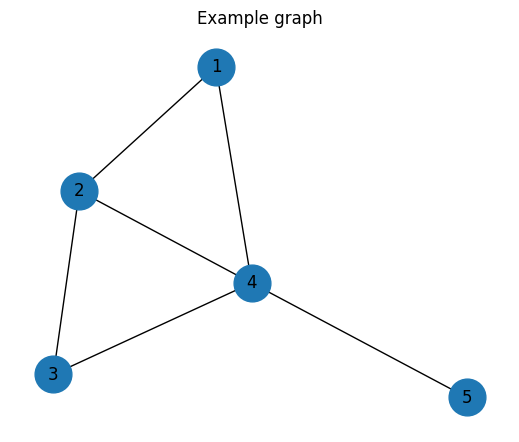

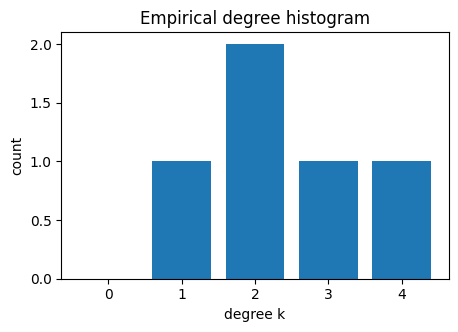

In [2]:
# A tiny example graph
G = nx.Graph()
G.add_edges_from([(1,2),(2,3),(3,4),(4,1),(2,4),(4,5)])  # a 4-cycle with one chord, plus a leaf 5–4

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# Degrees and average degree
deg = dict(G.degree())
avg_deg = 2*G.number_of_edges()/G.number_of_nodes()
print("Degrees:", deg)
print("Average degree (2L/N):", round(avg_deg,2))

# Degree sequence & histogram
deg_seq = [d for _, d in G.degree()]
vals, counts = np.unique(deg_seq, return_counts=True)
pk = counts / counts.sum()  # empirical degree distribution
print("k values:", vals)
print("p_k:", pk)

# Plot the graph (simple spring layout)
pos = nx.spring_layout(G, seed=0)
plt.figure(figsize=(5,4))
nx.draw(G, pos, with_labels=True, node_size=700)
plt.title("Example graph")
plt.show()

# Plot empirical degree histogram
plt.figure(figsize=(5,3.2))
plt.hist(deg_seq, bins=range(0, max(deg_seq)+2), align="left", rwidth=0.8)
plt.xlabel("degree k")
plt.ylabel("count")
plt.title("Empirical degree histogram")
plt.show()

## 2) Adjacency matrix and walks  *(Lecture 3)*
- The adjacency matrix $A$ encodes edges.  
- $(A^m)_{ij}$ counts the number of **walks** of length $m$ from $i$ to $j$.  
We'll check $m=2,3$ on the same toy graph.

In [3]:
A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()), dtype=int)
nodes = sorted(G.nodes())
print("Nodes order:", nodes)
print("A =\n", A)

A2 = A @ A
A3 = A2 @ A
print("\nA^2 (walks of length 2):\n", A2.astype(int))
print("\nA^3 (walks of length 3):\n", A3.astype(int))

# Example: number of triangles = trace(A^3)/6 for a simple graph
num_tri = int(np.trace(A3)//6)
print("\nTriangles =", num_tri)

Nodes order: [1, 2, 3, 4, 5]
A =
 [[0 1 0 1 0]
 [1 0 1 1 0]
 [0 1 0 1 0]
 [1 1 1 0 1]
 [0 0 0 1 0]]

A^2 (walks of length 2):
 [[2 1 2 1 1]
 [1 3 1 2 1]
 [2 1 2 1 1]
 [1 2 1 4 0]
 [1 1 1 0 1]]

A^3 (walks of length 3):
 [[2 5 2 6 1]
 [5 4 5 6 2]
 [2 5 2 6 1]
 [6 6 6 4 4]
 [1 2 1 4 0]]

Triangles = 2


## 3) Paths, distances, components, diameter, eccentricity  *(Lectures 4–5)*
- **Shortest paths** (unweighted): BFS-based in NetworkX.  
- **Connected components**.  
- **Eccentricity** of a node $v$: $\max_u d(u,v)$; **diameter**: $\max_v \text{ecc}(v)$.

Shortest 1→5: [1, 4, 5]  length: 2
Connected components: [{1, 2, 3, 4, 5}]
Eccentricities: {1: 2, 2: 2, 3: 2, 4: 1, 5: 2}
Diameter: 2


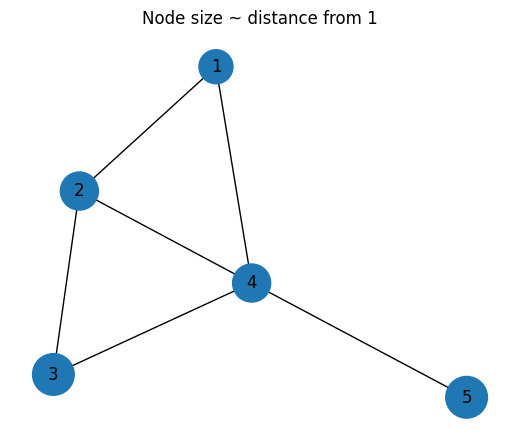

In [4]:
# Shortest paths and distances
sp_1_to_5 = nx.shortest_path(G, source=1, target=5)
dist_1_to_5 = nx.shortest_path_length(G, source=1, target=5)
print("Shortest 1→5:", sp_1_to_5, " length:", dist_1_to_5)

# Components
comps = list(nx.connected_components(G))
print("Connected components:", comps)

# Eccentricities and diameter
ecc = nx.eccentricity(G)  # dict: node -> ecc
diam = nx.diameter(G)
print("Eccentricities:", ecc)
print("Diameter:", diam)

# Visual hint: color by distance from node 1
dists = dict(nx.single_source_shortest_path_length(G, 1))
sizes = [600 + 150*dists[v] for v in G.nodes()]
plt.figure(figsize=(5,4))
nx.draw(G, pos, with_labels=True, node_size=sizes)
plt.title("Node size ~ distance from 1")
plt.show()

## 4) Isomorphism (VF2)  *(Lecture 3)*
Two graphs are **isomorphic** if there is a relabeling of nodes that preserves adjacency.

In [5]:
# Build H by relabeling G with a permutation
perm = {1:'a',2:'b',3:'c',4:'d',5:'e'}
H = nx.relabel_nodes(G, perm)
GM = nx.algorithms.isomorphism.GraphMatcher(G, H)
print("G ≅ H ?", GM.is_isomorphic())

G ≅ H ? True


## 5) Directed graphs: in/out-degree, SCCs  *(Lecture 4)*
Create a small **DiGraph**, inspect in/out-degrees, and compute **strongly connected components (SCCs)**. A strongly connected component of a directed graph $G = (V, E)$ is a maximal subset of vertices $C \subseteq V$ such that
for every pair of vertices $u, v \in C$:
$$u \text{ is reachable from } v \quad \text{and} \quad v \text{ is reachable from } u.$$

Nodes: 5 Edges: 5
Out-degrees: {'A': 1, 'B': 1, 'C': 2, 'D': 1, 'E': 0}
In-degrees : {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1}
Strongly connected components: [{'E'}, {'D'}, {'C', 'B', 'A'}]


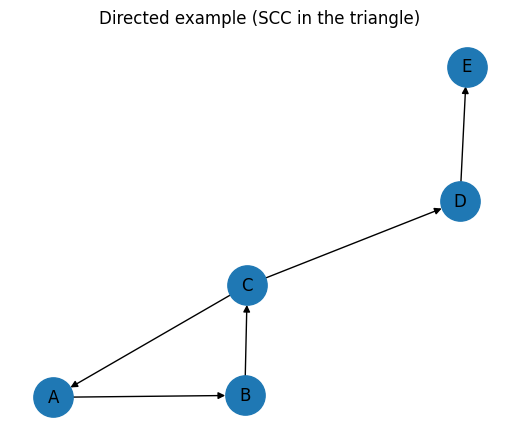

In [6]:
DG = nx.DiGraph()
DG.add_edges_from([
    ('A','B'), ('B','C'), ('C','A'),  # a 3-cycle (one SCC)
    ('C','D'), ('D','E')              # a tail out of the cycle
])

print("Nodes:", DG.number_of_nodes(), "Edges:", DG.number_of_edges())
print("Out-degrees:", dict(DG.out_degree()))
print("In-degrees :", dict(DG.in_degree()))

sccs = list(nx.strongly_connected_components(DG))
print("Strongly connected components:", sccs)

plt.figure(figsize=(5,4))
pos_d = nx.spring_layout(DG, seed=1)
nx.draw(DG, pos_d, with_labels=True, node_size=800, arrows=True)
plt.title("Directed example (SCC in the triangle)")
plt.show()

## 6) Weighted graphs: Dijkstra shortest paths  *(Lecture 4)*
Give each edge a **weight** and compute a shortest path by **total weight**. We did not discuss this in class in too much detail. An efficient algorithm to do it is called the Dijkstra algorithm. Here we compute the "cheapest"path between $s$ and $t$.

Weighted shortest path s→t: ['s', 'b', 'c', 't']  total weight: 8


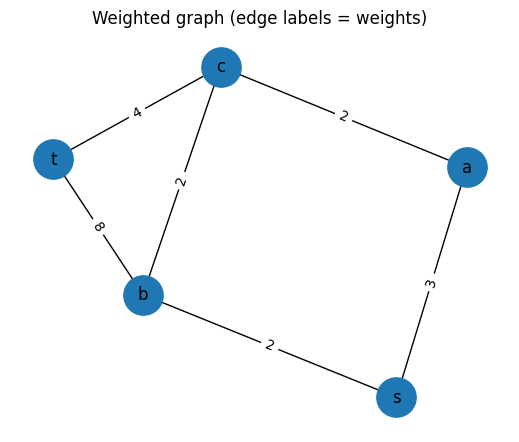

In [8]:
WG = nx.Graph()
WG.add_weighted_edges_from([
    ('s','a', 3), ('s','b', 2), ('a','c', 2),
    ('b','c', 2), ('c','t', 4), ('b','t', 8)
])

path = nx.shortest_path(WG, 's', 't', weight='weight')
dist = nx.shortest_path_length(WG, 's', 't', weight='weight')
print("Weighted shortest path s→t:", path, " total weight:", dist)

pos_w = nx.spring_layout(WG, seed=2)
plt.figure(figsize=(5,4))
nx.draw(WG, pos_w, with_labels=True, node_size=800)
edge_labels = nx.get_edge_attributes(WG, 'weight')
nx.draw_networkx_edge_labels(WG, pos_w, edge_labels=edge_labels)
plt.title("Weighted graph (edge labels = weights)")
plt.show()

## 7) Centralities quick look  *(Lectures 5–6)*
Contrast **degree**, **closeness**, **betweenness**, **eigenvector**, and **PageRank** on a small graph.

Top nodes by centrality on Karate club:
Degree     : [(33, 0.5151515151515151), (0, 0.48484848484848486), (32, 0.36363636363636365)]
Closeness  : [(0, 0.5689655172413793), (2, 0.559322033898305), (33, 0.55)]
Betweenness: [(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114)]
Eigenvector: [(33, 0.37337121301323506), (0, 0.35548349418519426), (2, 0.3171893899684447)]
PageRank   : [(33, 0.09698041880501741), (0, 0.08850807396280012), (32, 0.07592643687005646)]


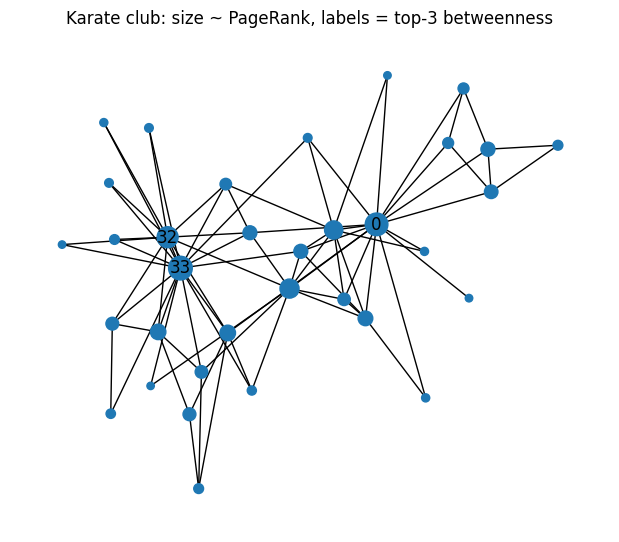

In [10]:
H = nx.karate_club_graph()  # classic toy
deg_c = nx.degree_centrality(H)
clo_c = nx.closeness_centrality(H)
bet_c = nx.betweenness_centrality(H)
eig_c = nx.eigenvector_centrality(H)  # power method
pr_c  = nx.pagerank(H, alpha=0.85)

def topk(d, k=3):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

print("Top nodes by centrality on Karate club:")
print("Degree     :", topk(deg_c))
print("Closeness  :", topk(clo_c))
print("Betweenness:", topk(bet_c))
print("Eigenvector:", topk(eig_c))
print("PageRank   :", topk(pr_c))

# Visual: size by PageRank, label top-3 by betweenness
posK = nx.spring_layout(H, seed=4)
sizes = [3000*pr_c[v] for v in H.nodes()]
plt.figure(figsize=(6,5))
nx.draw(H, posK, node_size=sizes, with_labels=False)
lab_nodes = [v for v,_ in topk(bet_c, k=3)]
nx.draw_networkx_labels(H, posK, labels={v:str(v) for v in lab_nodes})
plt.title("Karate club: size ~ PageRank, labels = top-3 betweenness")
plt.show()

## 8) Mini exercises (optional)
1. Build a bipartite graph with left/right partitions of sizes 4 and 6. Compute its degree distribution and average clustering.  
2. Create two non-isomorphic graphs with the same degree sequence (e.g., both 3-regular on 8 nodes). Verify with the isomorphism checker.  
3. For a directed ER graph (`nx.gnp_random_graph(..., directed=True)`), estimate the size of the largest SCC as $N$ grows.

## 9) Random walks in action
- On undirected connected graphs, the random walk stationary distribution is proportional to degree.  

The following code shows the empirical stationary distribution converging to proportional-to-degree.

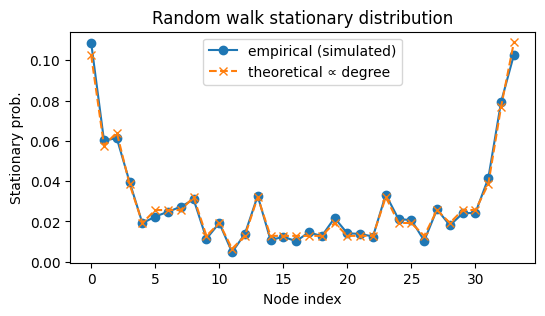

In [14]:
import numpy as np, random

# Example: small undirected graph
G = nx.karate_club_graph()

# Start random walk from a random node
steps = 10_000
node = random.choice(list(G.nodes())) # pick a random starting point
visits = {v: 0 for v in G.nodes()}

#while running the process, record how offen you visit each node. This is a proxy for the empirical distribution.

for _ in range(steps): # run the process 'steps' times
    visits[node] += 1
    neighbors = list(G.neighbors(node))
    node = random.choice(neighbors)

# Empirical stationary distribution
pi_emp = np.array([visits[v]/steps for v in G.nodes()])
pi_theory = np.array([d/sum(dict(G.degree()).values()) for _, d in G.degree()])

# Compare empirical vs theoretical
plt.figure(figsize=(6,3))
plt.plot(pi_emp, 'o-', label="empirical (simulated)")
plt.plot(pi_theory, 'x--', label="theoretical ∝ degree")
plt.xlabel("Node index")
plt.ylabel("Stationary prob.")
plt.title("Random walk stationary distribution")
plt.legend()
plt.show()

- On directed graphs, **teleportation** (PageRank) ensures a unique stationary distribution even with sinks.
Try: pick a small directed graph with a sink node and compare `nx.pagerank(D, alpha=0.85)` with `nx.hits(D)`.


Without teleportation, the random walk would eventually die in node D.

PageRank adds a probability 1-\alpha of jumping anywhere — guaranteeing a well-defined steady state.

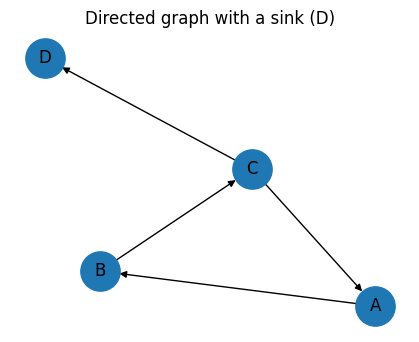

HITS authority: {'A': 0.5, 'B': -0.0, 'C': -0.0, 'D': 0.5}
PageRank: {'A': 0.2137621842472386, 'B': 0.26462302680270133, 'C': 0.3078526047028215, 'D': 0.2137621842472386}


In [12]:
D = nx.DiGraph()
D.add_edges_from([
    ('A','B'), ('B','C'), ('C','A'),
    ('C','D'),  # D is a sink
])

plt.figure(figsize=(4,3))
nx.draw(D, with_labels=True, node_size=800, arrows=True)
plt.title("Directed graph with a sink (D)")
plt.show()

# Compare stationary distribution and PageRank
try:
    pi_hits = nx.hits(D)
    pr = nx.pagerank(D, alpha=0.85)
    print("HITS authority:", pi_hits[1])
    print("PageRank:", pr)
except Exception as e:
    print(e)

#  Visualization: PageRank on a mini web

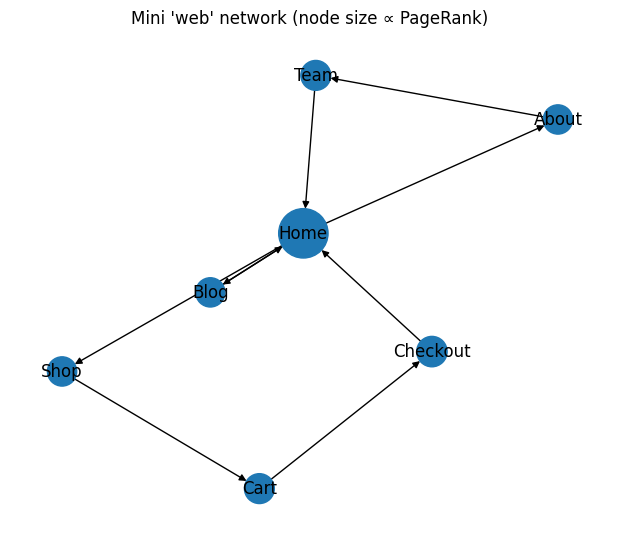

In [13]:
web = nx.DiGraph()
web.add_edges_from([
    ("Home", "About"), ("Home", "Shop"), ("Shop", "Cart"),
    ("Cart", "Checkout"), ("Checkout", "Home"),
    ("About", "Team"), ("Team", "Home"), ("Home", "Blog"),
    ("Blog", "Home")
])

pr = nx.pagerank(web, alpha=0.85)
sizes = [4000*v for v in pr.values()]
plt.figure(figsize=(6,5))
pos = nx.spring_layout(web, seed=2)
nx.draw(web, pos, with_labels=True, node_size=sizes, arrows=True)
plt.title("Mini 'web' network (node size ∝ PageRank)")
plt.show()